# Modèle pre-entrainer XCEPTION : classification binaire COVID / SAIN (NORMAL) par extraction de features

In [1]:
# Chargement des modules nécessaires :

import os

import random
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Model

In [2]:
# On déclare les chemins vers les données :

Image = 'Data'
        
train_data_dir = 'Data/TRAIN'
validation_data_dir = 'Data/VALIDATION'
test_data_dir = 'Data/TEST'

# Dimensions et path :
img_width, img_height = 224, 224

ImageTRAINCOVID = os.listdir(Image + '/TRAIN/COVID19')
ImageTRAINNORMAL = os.listdir(Image + '/TRAIN/NORMAL')

ImageVALIDATIONCOVID = os.listdir(Image + '/VALIDATION/COVID19')
ImageVALIDATIONNORMAL = os.listdir(Image + '/VALIDATION/NORMAL')

ImageTESTCOVID = os.listdir(Image + '/TEST/COVID19')
ImageTESTNORMAL = os.listdir(Image + '/TEST/NORMAL')

print('Il y a ' + str(len(ImageTRAINCOVID)) + ' images d\'entrainement de patient covid.') 
print('Il y a ' + str(len(ImageTRAINNORMAL)) + ' images d\'entrainement de patient non-covid.') 
print('Il y a ' + str(len(ImageVALIDATIONCOVID)) + ' images de validation de patient covid.') 
print('Il y a ' + str(len(ImageVALIDATIONNORMAL)) + ' images de validation de patient non-covid.') 
print('Il y a ' + str(len(ImageTESTCOVID)) + ' images test de patient covid.') 
print('Il y a ' + str(len(ImageTESTNORMAL)) + ' images test de patient non-covid.') 

Il y a 460 images d'entrainement de patient covid.
Il y a 1266 images d'entrainement de patient non-covid.
Il y a 116 images de validation de patient covid.
Il y a 317 images de validation de patient non-covid.
Il y a 219 images test de patient covid.
Il y a 1341 images test de patient non-covid.


TRAIN COVID


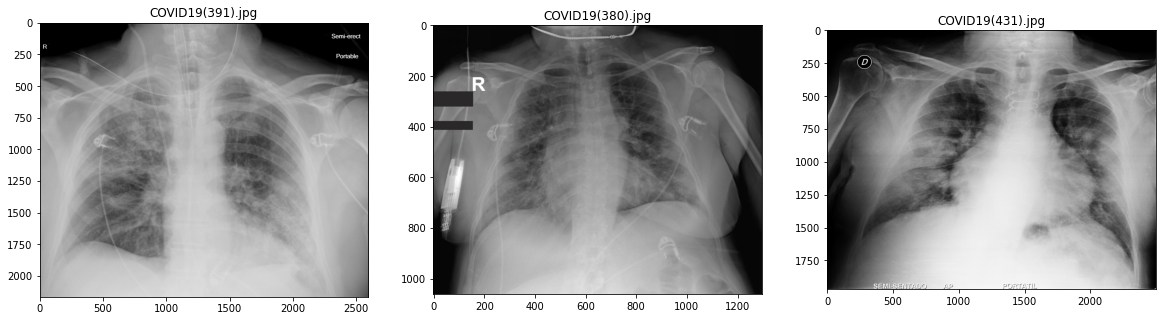

TEST COVID


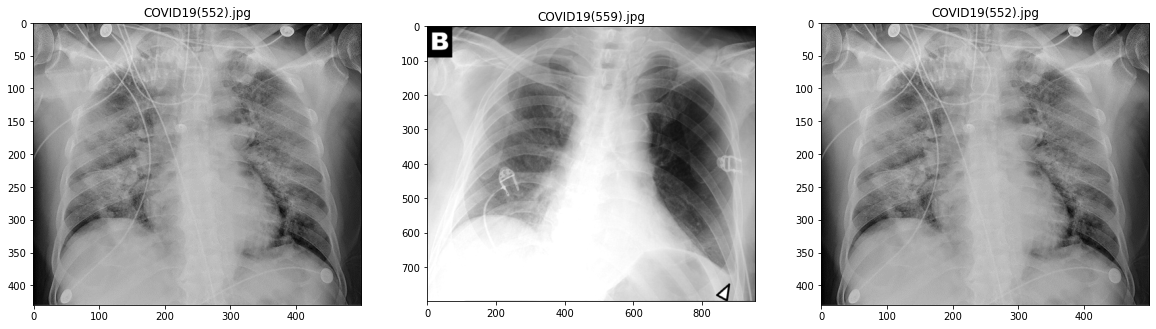

TRAIN NORMAL


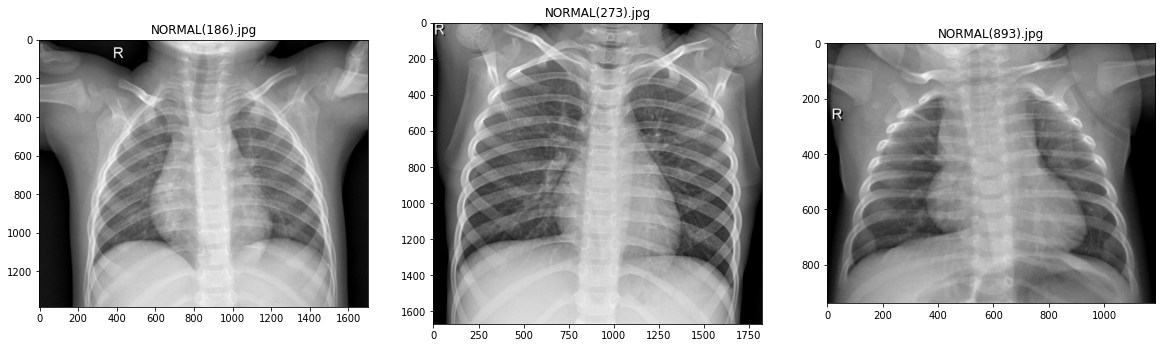

TEST NORMAL


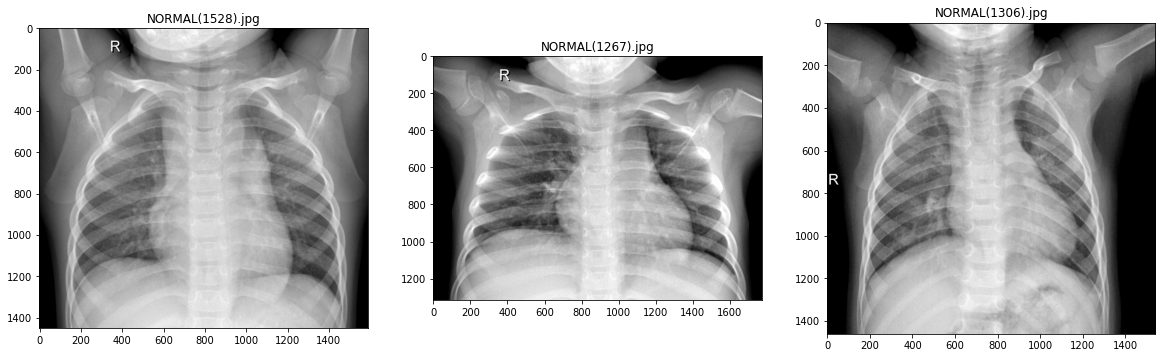

In [3]:
# Visualisation de 6 exemples en 2 lignes et 3 colonnes pour chaque classe :

# TRAIN :

print("TRAIN COVID")


# COVID  :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTRAINCOVID = random.choice(os.listdir(train_data_dir + '/COVID19'))
    plt.imshow(plt.imread(os.path.join( train_data_dir +'/COVID19',randomImageTRAINCOVID)), cmap='gray')
    plt.title(randomImageTRAINCOVID)
    
plt.show()

print("TEST COVID")
# COVID  :
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTESTCOVID = random.choice(os.listdir(validation_data_dir + '/COVID19'))
    plt.imshow(plt.imread(os.path.join(validation_data_dir +'/COVID19',randomImageTESTCOVID)), cmap='gray')
    plt.title(randomImageTESTCOVID)
    
plt.show()

print("TRAIN NORMAL")
# NORMAL :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTRAINNORMAL = random.choice(os.listdir(train_data_dir + '/NORMAL'))
    plt.imshow(plt.imread(os.path.join(train_data_dir +'/NORMAL',randomImageTRAINNORMAL)), cmap='gray')
    plt.title(randomImageTRAINNORMAL)
    
plt.show()


# TEST:

print("TEST NORMAL")

# NORMAL :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTESTNORMAL = random.choice(os.listdir(validation_data_dir + '/NORMAL'))
    plt.imshow(plt.imread(os.path.join(validation_data_dir +'/NORMAL',randomImageTESTNORMAL)), cmap='gray')
    plt.title(randomImageTESTNORMAL)
    
plt.show()


In [4]:
# Pré-processing :

# On rescale les images :
datagen = ImageDataGenerator(rescale=1./255)

# On définit la batch size :
batch_size = 32

# On prépare les tableaux de données depuis les images :

train_generator_bottleneck = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

validation_generator_bottleneck = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

test_generator_bottleneck = datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)


Found 1726 images belonging to 2 classes.
Found 433 images belonging to 2 classes.
Found 1560 images belonging to 2 classes.


In [5]:
# Chargement de XCEPTION sans la partie fully-connected avec le reseau convolutif :

model_XCEPTION = applications.Xception(include_top=False, weights='imagenet')

In [6]:
# On utilise le model XCEPTION pour extraire les features de nos images 
# on récupère la sortie du reseau convolutionnel :

train_features = model_XCEPTION.predict_generator(train_generator_bottleneck, 1726 // batch_size)

np.save(open('models/trainFeatures_XCEPTION_AllData.npy', 'wb'), train_features)

validation_features = model_XCEPTION.predict_generator(validation_generator_bottleneck, 433 // batch_size)

# L'opération étant longue on enregistre les features obtenues :

np.save(open('models/validationFeatures_XCEPTION_AllData.npy', 'wb'), validation_features)

test_features = model_XCEPTION.predict_generator(test_generator_bottleneck, 1560 // batch_size)

np.save(open('models/testFeatures_XCEPTION_AllData.npy', 'wb'), test_features)

/Users/chourouk/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [7]:
# Si l'opération a déjà été effectuées on charge les features :

train_features = np.load(open('models/trainFeatures_XCEPTION_AllData.npy', 'rb'))

validation_features = np.load(open('models/validationFeatures_XCEPTION_AllData.npy', 'rb'))

test_features = np.load(open('models/testFeatures_XCEPTION_AllData.npy', 'rb'))

In [8]:
# On définit les labels :

train_labels = np.array([0] * 448 + [1] * 1248)
validation_labels = np.array([0] * 116 + [1] * 300)
test_labels = np.array([0] * 219 + [1] * 1317)

# On peut maintenant tester plusieurs couche fully-connected à partir de ce modèle :

In [9]:
# Premier modèle : 

model_top1 = Sequential()
model_top1.add(Flatten(input_shape=train_features.shape[1:]))
model_top1.add(Dense(64, activation='relu'))
model_top1.add(Dropout(0.5))
model_top1.add(Dense(1, activation='sigmoid'))


# On compile :

model_top1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :

model_top1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 6,422,657
Trainable params: 6,422,657
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Second modèle :

model_top2 = Sequential()
model_top2.add(Flatten(input_shape=train_features.shape[1:]))
model_top2.add(Dense(128, activation='relu'))
model_top2.add(Dropout(0.5))
model_top2.add(Dense(1, activation='sigmoid'))


# On compile :

model_top2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :

model_top2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               12845184  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 12,845,313
Trainable params: 12,845,313
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Troisieme modèle :

model_top3 = Sequential()
model_top3.add(Flatten(input_shape=train_features.shape[1:]))
model_top3.add(Dense(256, activation='relu'))
model_top3.add(Dropout(0.5))
model_top3.add(Dense(1, activation='sigmoid'))


# On compile :

model_top3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :

model_top3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 25,690,625
Trainable params: 25,690,625
Non-trainable params: 0
_________________________________________________________________


In [12]:
# On définit les paramètres pour l'entrainement :
epochs = 100
train_samples = 802
validation_samples = 204

# On definit les callbacks : 
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience = 10,restore_best_weights=True,),
]

In [13]:
# On entraine le modèle 1:

hystory1 = model_top1.fit(train_features, train_labels,
        epochs=epochs, 
        callbacks = my_callbacks,
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))

Epoch 1/100
53/53 [==============================] - 16s 240ms/step - loss: 2.0689 - accuracy: 0.8968 - val_loss: 0.0578 - val_accuracy: 0.9880
Epoch 2/100
53/53 [==============================] - 8s 142ms/step - loss: 0.1872 - accuracy: 0.9758 - val_loss: 0.0444 - val_accuracy: 0.9880
Epoch 3/100
53/53 [==============================] - 8s 145ms/step - loss: 0.1496 - accuracy: 0.9756 - val_loss: 0.0350 - val_accuracy: 0.9880
Epoch 4/100
53/53 [==============================] - 8s 159ms/step - loss: 0.1905 - accuracy: 0.9767 - val_loss: 1.0377e-04 - val_accuracy: 1.0000
Epoch 5/100
53/53 [==============================] - 8s 144ms/step - loss: 0.1835 - accuracy: 0.9790 - val_loss: 0.0555 - val_accuracy: 0.9904
Epoch 6/100
53/53 [==============================] - 9s 163ms/step - loss: 0.0634 - accuracy: 0.9869 - val_loss: 0.0205 - val_accuracy: 0.9952
Epoch 7/100
53/53 [==============================] - 8s 158ms/step - loss: 0.1421 - accuracy: 0.9782 - val_loss: 9.3241e-04 - val_accurac

In [14]:
n_epochs = len(hystory1.history['loss'])
GenOptimale1 = n_epochs-10
print("la generation optimale est : ",GenOptimale1)
model_top1.save_weights('../memory/Weights/xception_lightTop_224_224_'+str(GenOptimale1)+'.h5')

la generation optimale est :  4


In [15]:
# On entraine le modèle 2:

hystory2 = model_top2.fit(train_features, train_labels,
        epochs=epochs, 
        callbacks = my_callbacks,
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))

Epoch 1/100
53/53 [==============================] - 19s 310ms/step - loss: 2.1614 - accuracy: 0.8941 - val_loss: 0.2975 - val_accuracy: 0.9832
Epoch 2/100
53/53 [==============================] - 16s 301ms/step - loss: 0.4833 - accuracy: 0.9638 - val_loss: 0.0031 - val_accuracy: 0.9976
Epoch 3/100
53/53 [==============================] - 17s 314ms/step - loss: 0.1725 - accuracy: 0.9747 - val_loss: 0.0178 - val_accuracy: 0.9952
Epoch 4/100
53/53 [==============================] - 14s 264ms/step - loss: 0.2266 - accuracy: 0.9764 - val_loss: 0.0173 - val_accuracy: 0.9952
Epoch 5/100
53/53 [==============================] - 14s 258ms/step - loss: 0.0607 - accuracy: 0.9911 - val_loss: 0.0095 - val_accuracy: 0.9976
Epoch 6/100
53/53 [==============================] - 13s 245ms/step - loss: 0.1337 - accuracy: 0.9851 - val_loss: 0.0108 - val_accuracy: 0.9952
Epoch 7/100
53/53 [==============================] - 12s 234ms/step - loss: 0.1021 - accuracy: 0.9849 - val_loss: 0.0323 - val_accuracy:

In [16]:
n_epochs = len(hystory2.history['loss'])
GenOptimale2 = n_epochs-10
print("la generation optimale est : ",GenOptimale2)
model_top2.save_weights('../memory/Weights/xception_mediumTop_224_224_'+str(GenOptimale2)+'.h5')

la generation optimale est :  24


In [17]:
# On entraine le modèle 3:

hystory3 = model_top3.fit(train_features, train_labels,
        epochs=epochs, 
        callbacks = my_callbacks,
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))

Epoch 1/100
53/53 [==============================] - 31s 555ms/step - loss: 3.9609 - accuracy: 0.8877 - val_loss: 0.0489 - val_accuracy: 0.9976
Epoch 2/100
53/53 [==============================] - 30s 567ms/step - loss: 0.6068 - accuracy: 0.9752 - val_loss: 0.1352 - val_accuracy: 0.9856
Epoch 3/100
53/53 [==============================] - 26s 493ms/step - loss: 0.3338 - accuracy: 0.9816 - val_loss: 0.0395 - val_accuracy: 0.9952
Epoch 4/100
53/53 [==============================] - 25s 470ms/step - loss: 0.2413 - accuracy: 0.9791 - val_loss: 0.0023 - val_accuracy: 0.9976
Epoch 5/100
53/53 [==============================] - 23s 443ms/step - loss: 0.3137 - accuracy: 0.9803 - val_loss: 0.1095 - val_accuracy: 0.9952
Epoch 6/100
53/53 [==============================] - 28s 525ms/step - loss: 0.1245 - accuracy: 0.9901 - val_loss: 0.0904 - val_accuracy: 0.9832
Epoch 7/100
53/53 [==============================] - 24s 455ms/step - loss: 0.1217 - accuracy: 0.9894 - val_loss: 4.7305e-05 - val_accur

In [18]:
n_epochs = len(hystory3.history['loss'])
GenOptimale3 = n_epochs-10
print("la generation optimale est : ",GenOptimale3)
model_top3.save_weights('../memory/Weights/xception_heavyTop_224_224_'+str(GenOptimale3)+'.h5')

la generation optimale est :  7


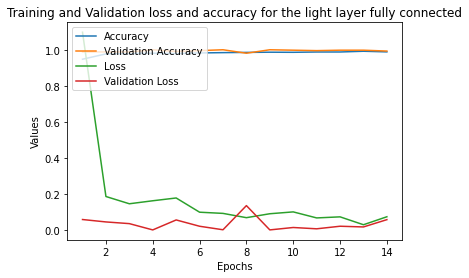

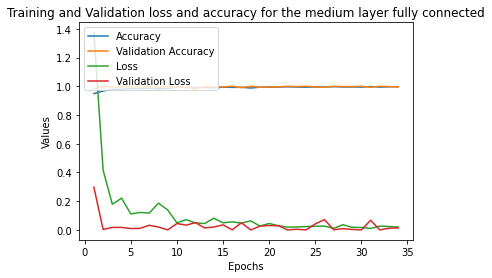

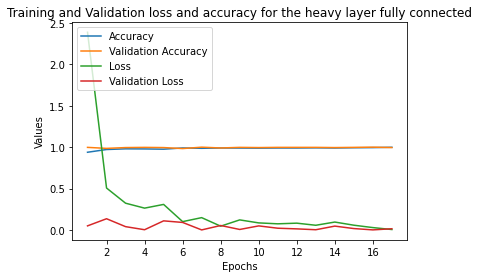

In [19]:
# Visualisation de l'entrainement :

epochs = range(1,15)
plt.plot(epochs, hystory1.history['accuracy'], label='Accuracy')
plt.plot(epochs, hystory1.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, hystory1.history['loss'], label='Loss')
plt.plot(epochs, hystory1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the light layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()

epochs = range(1,35)
plt.plot(epochs, hystory2.history['accuracy'], label='Accuracy')
plt.plot(epochs, hystory2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, hystory2.history['loss'], label='Loss')
plt.plot(epochs, hystory2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the medium layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()

epochs = range(1,18)
plt.plot(epochs, hystory3.history['accuracy'], label='Accuracy')
plt.plot(epochs, hystory3.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, hystory3.history['loss'], label='Loss')
plt.plot(epochs, hystory3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the heavy layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()



In [20]:
# On évalue :

# Avec les données de validation :
eval1 = model_top1.evaluate(validation_features, validation_labels,verbose=2)
eval2 = model_top2.evaluate(validation_features, validation_labels,verbose=2)
eval3 = model_top3.evaluate(validation_features, validation_labels,verbose=2)

# Avec les données de test :
evaltest1 = model_top1.evaluate(test_features, test_labels,verbose=2)
evaltest2 = model_top2.evaluate(test_features, test_labels,verbose=2)
evaltest3 = model_top3.evaluate(test_features, test_labels,verbose=2)


13/13 - 1s - loss: 1.0377e-04 - accuracy: 1.0000
13/13 - 0s - loss: 1.8203e-05 - accuracy: 1.0000
13/13 - 1s - loss: 4.7305e-05 - accuracy: 1.0000
48/48 - 4s - loss: 0.0899 - accuracy: 0.9961
48/48 - 2s - loss: 0.1956 - accuracy: 0.9954
48/48 - 4s - loss: 0.1560 - accuracy: 0.9954


## Enregistrements (facultatifs)

In [21]:
#On enregistre les historiques:

np.save('../memory/history/historique_chourouk_xception_224_224_light_'+str(GenOptimale1)+'.npy',hystory1.history)
np.save('../memory/history/historique_chourouk_xception_224_224_medium_'+str(GenOptimale2)+'.npy',hystory2.history)
np.save('../memory/history/historique_chourouk_xception_224_224_heavy_'+str(GenOptimale3)+'.npy',hystory3.history)